# 3D Rendering
* Raster drawing (2D)
* Projecting a point cloud
* Rotations
* Drawing a triangle
* Mesh representation
* Z-buffering
* Darth Vader

## Raster drawing

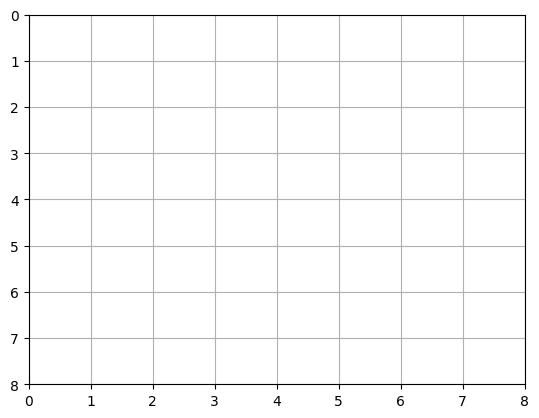

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True)); ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlim([0, 8])
ax.set_ylim([8, 0])
plt.grid()

In [3]:
import numpy as np

In [4]:
resolution = 320, 200
w, h = resolution
# Allocate a byte buffer. 0 = black, 255 = white
buffer = np.zeros((h, w, 1), dtype=np.uint8)

In [5]:
n = 512
np.random.seed(17)  # official KTH random number
pixels = 0.5 * np.array(resolution) + np.random.normal(size=(n, 2)) * 24

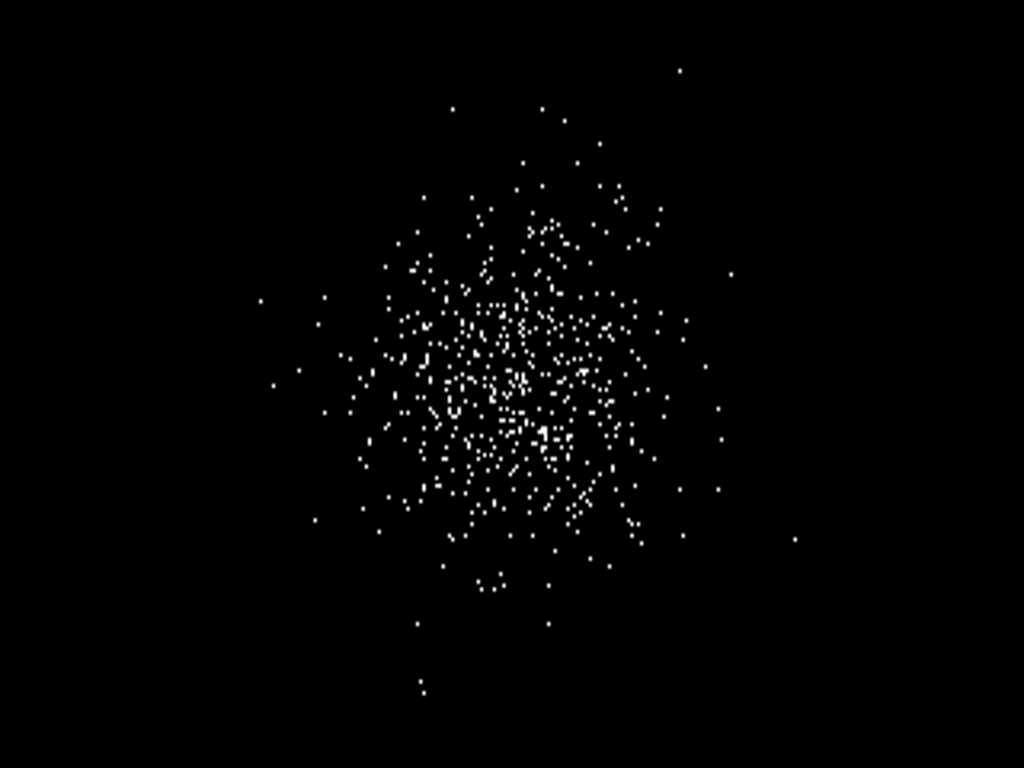

In [6]:
from typing import Tuple
from PIL import Image

def create_buffer(resolution: Tuple[int, int]):
    w, h = resolution
    return np.zeros((h, w, 3), dtype=np.uint8)

def draw_pixels(buffer: np.ndarray, pixels: np.ndarray) -> None:
    assert pixels.shape[1] == 2
    h, w, _ = buffer.shape
    for sx, sy in pixels.astype(int):
        if 0 < sx < w and 0 < sy < h:
            buffer[sy, sx] = 255, 255, 255

def show_buffer(buffer: np.ndarray) -> None:
    return Image.fromarray(buffer).resize((1024, 768))
    
buffer = create_buffer(resolution)
draw_pixels(buffer, pixels)
show_buffer(buffer)

## Projection

In [7]:
vertices = np.random.normal(size=(n, 3))

In [8]:
def orthographic(vertices: np.ndarray) -> np.ndarray:
    assert vertices.shape[1] == 3
    # just drop (ignore) z values
    return vertices[:, :2]  # first column means return all rows, :2 means return first two columns (but not the third which is z)

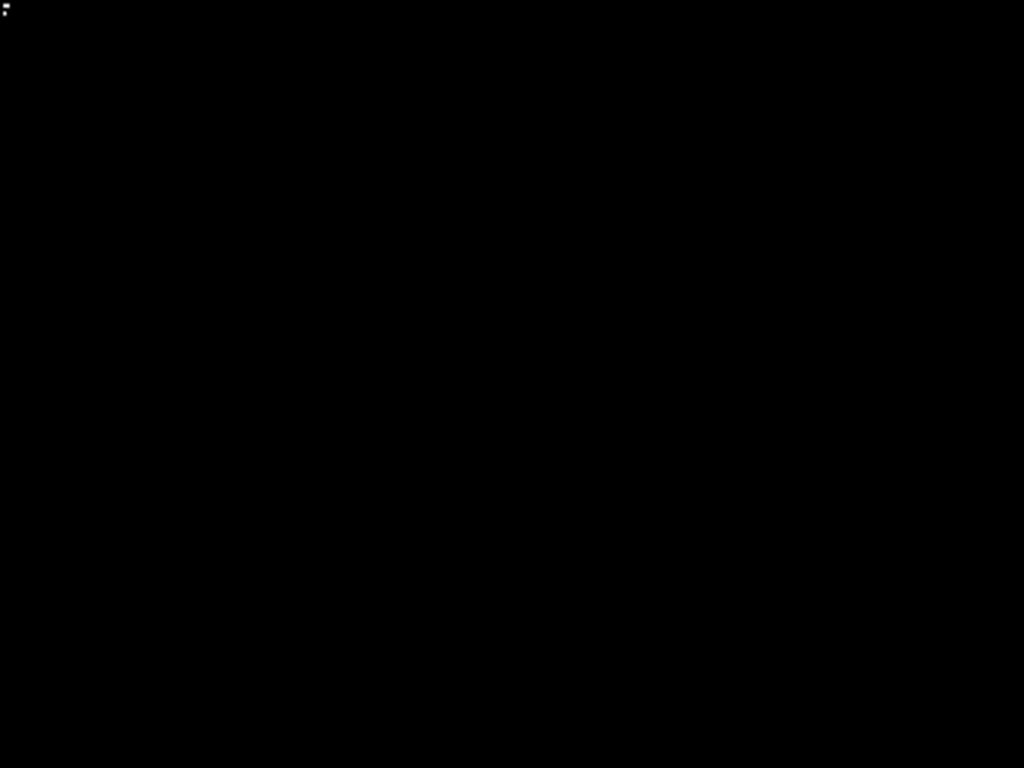

In [9]:
buffer = create_buffer(resolution)
draw_pixels(buffer, orthographic(vertices))
show_buffer(buffer)

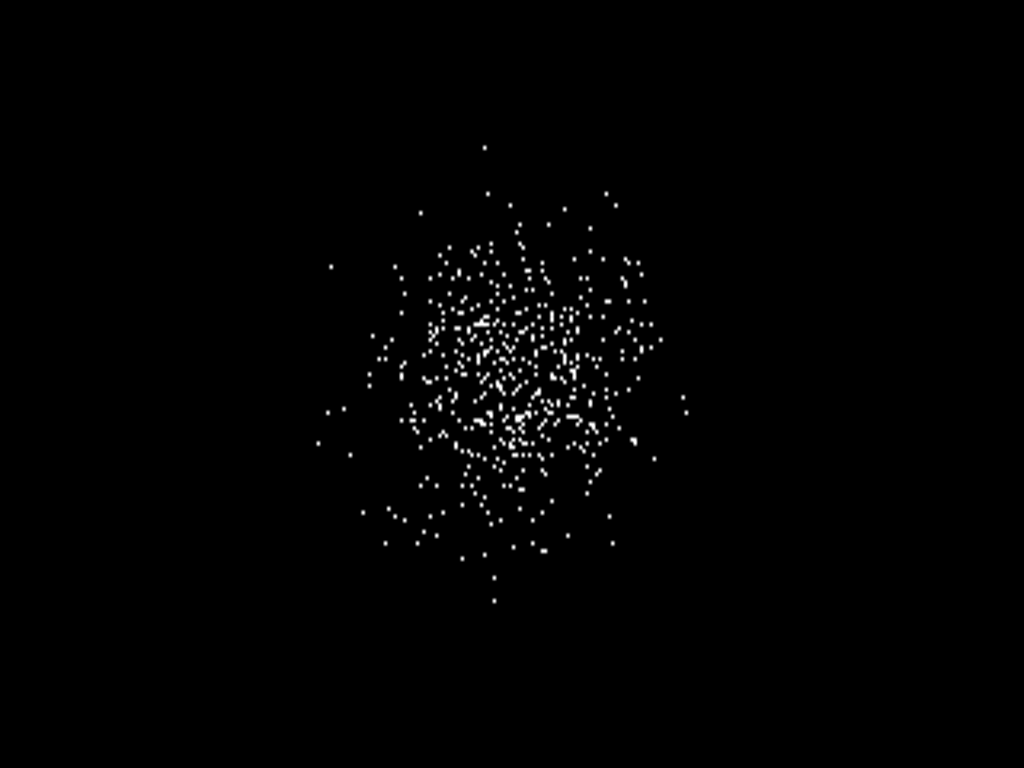

In [32]:
def to_screen(ndc: np.ndarray, resolution: Tuple[int, int]) -> np.ndarray:
    """Transforms pixels from the NDC cordinate system (-1 to 1) to the specificed resolution"""
    scale = np.min(resolution)
    return 0.5 * np.array(resolution) + scale * ndc

vertices = np.random.normal(size=(n, 3)) * 0.1  # smaller point cloud so it fits within the resolution
buffer = create_buffer(resolution)
draw_pixels(buffer, to_screen(orthographic(vertices), resolution))
show_buffer(buffer)

In [11]:
def transform(m: np.ndarray, points: np.ndarray) -> np.ndarray:
    """Transforms all points in `points` according to the transformation matrix `m`"""
    assert points.shape[1] == 3
    return (np.dot(m, points.T)).T

In [12]:
from math import cos, sin, pi
tau = 2 * pi

theta = 1/8 * tau
def rotate_y(theta: float) -> np.ndarray:
    return np.array([
        [cos(theta), 0, -sin(theta)],
        [         0, 1,          0],
        [sin(theta), 0,  cos(theta)],
    ])

transform(rotate_y(theta), vertices)

array([[-0.09693572,  0.02205716, -0.25516053],
       [ 0.05540903, -0.0105965 , -0.03457923],
       [ 0.03083595, -0.01493581, -0.06769792],
       ...,
       [-0.01167996, -0.16642424, -0.02036237],
       [-0.02971751,  0.11118573, -0.0295648 ],
       [-0.07920809, -0.18556403,  0.00889568]])

In [13]:
# Some iphython stuff to display gifs
from typing import List
import IPython.display

def display_gif(frames: List[np.ndarray], framerate: float, **kwargs) -> IPython.display.Image:
    images = [Image.fromarray(frame) for frame in frames]
    images[0].save('1.gif', save_all=True, append_images=images[1:], duration=framerate * len(images), loop=0)
    return IPython.display.Image(url="1.gif", **kwargs)

In [14]:
from typing import Callable

def draw_frame(m: np.ndarray, vertices: np.ndarray, project: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
    transformed = transform(m, vertices)  # transform vertices
    ndc = project(transformed)  # project vertices into ndc
    pixels = to_screen(ndc, resolution)  # convert to screen space (resolution of buffer)
    draw_pixels(buffer, pixels)  # draw pixels
    return buffer

#vertices = np.random.uniform(-1, 1, size=(n, 3)) * 0.1
#vertices = np.random.normal(size=(n, 3)) * 0.1

transforms = (rotate_y(theta) for theta in np.linspace(0, tau, 200))
frames = [draw_frame(transform, vertices, project=orthographic) for transform in transforms]
display_gif(frames, framerate=1/30, width=1024)

## Perspective
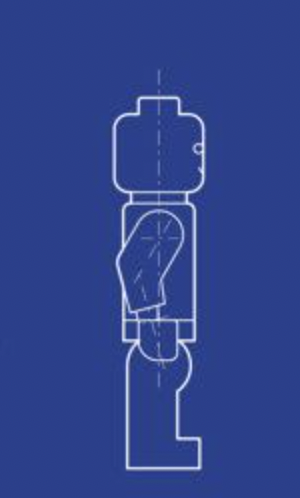

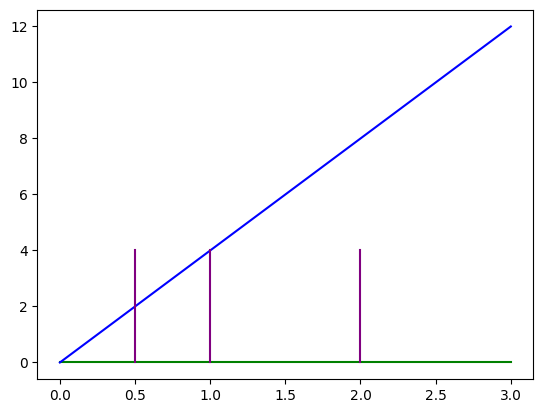

In [15]:
plt.plot([0, 3], [0, 0], 'green')  # ground
plt.plot([0, 3], [0, 12], 'blue')  # line of sight
plt.plot([1, 1], [0, 4], 'purple')  # minifig at z=1
plt.plot([2, 2], [0, 4], 'purple')  # minifig at z=2
plt.plot([0.5, 0.5], [0, 4], 'purple')  # minifig at z=0.5

Apparent height $y = h / z$

In [16]:
def perspective(vertices: np.ndarray) -> np.ndarray:
    z = vertices[:, 2][:, np.newaxis]  # all z-values
    return vertices[:, :2] / z  # pick x and y values and divide each row (vertex) with the corresponding z-value

In [17]:
transforms = (rotate_y(theta) for theta in np.linspace(0, tau, 200))
frames = [draw_frame(transform, vertices, project=perspective) for transform in transforms]
display_gif(frames, framerate=1/30, width=512)

In [18]:
# updated function with a translation parameter t
def draw_frame(m: np.ndarray, t: np.ndarray, vertices: np.ndarray, project: Callable[[np.ndarray], np.ndarray]) -> np.ndarray:
    buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
    transformed = transform(m, vertices) + t # transform vertices
    ndc = project(transformed)  # project vertices into ndc
    pixels = to_screen(ndc, resolution)  # convert to screen space (resolution of buffer)
    draw_pixels(buffer, pixels)  # draw pixels
    return buffer

In [38]:
t = np.array([0, 0, 0.5])
transforms = (rotate_y(theta) for theta in np.linspace(0, tau, 200))
frames = [draw_frame(transform, t, vertices, project=perspective) for transform in transforms]
display_gif(frames, framerate=1/30, width=512)

## Triangles

[ 0.17479511  0.10281769 -0.11198433] [-0.13533847  0.05443048  0.02604213]


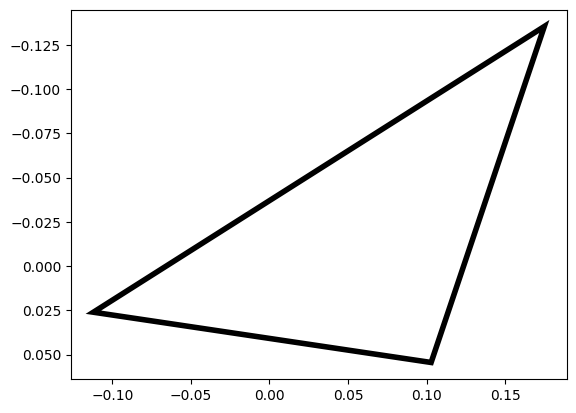

In [34]:
triangle = (0, 1, 2)  # pick the first three vertices to work with
xs = vertices[triangle, 0]
ys = vertices[triangle, 1]
print(xs, ys)
plt.fill(xs, ys, fill=False, lw=4)
plt.gca().invert_yaxis()

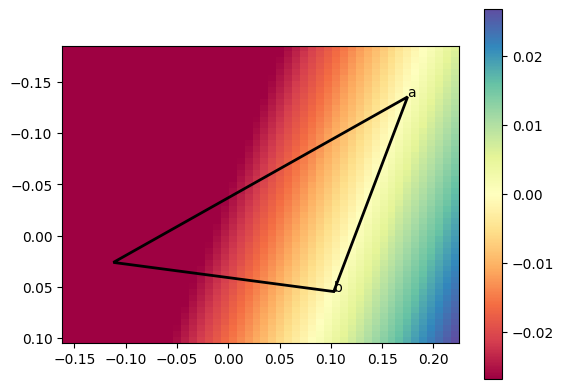

In [35]:
# barycentric cordinates
def edge(p0: np.ndarray, p1: np.ndarray, p: np.ndarray) -> float:
    """Computes the edge function at point p for the edge p0 -> p1. Arguments are either (1, 2) arrays or
    (n, 2) arrays. Broadcasting rules apply."""
    assert all(a.shape[1] == 2 for a in (p0, p1, p))  # all arrays must have two columns
    return (p[:, 0] - p0[:, 0]) * (p1[:, 1] - p0[:, 1])  - (p[:, 1] - p0[:, 1]) * (p1[:, 0] - p0[:, 0])

# find the bounding box, with some padding
padding = 0.05
xmin, xmax = np.min(xs) - padding, np.max(xs) + padding
ymin, ymax = np.min(ys) - padding, np.max(ys) + padding
X, Y = np.meshgrid(np.linspace(xmin, xmax), np.linspace(ymin, ymax))  # arrange a gridspace on the bounding box

# get the three points of the triangle
a, b, c = np.vsplit(vertices[triangle, :2], 3)

p = np.vstack([X.ravel(), Y.ravel()]).T  # arrange all the points of the grid as a list of points
ab = edge(a, b, p)  # evaluate the edge-function a -> b for all the points p in the bounding box (p)

from matplotlib import colormaps
plt.imshow(
    ab.reshape(X.shape),
    extent=(xmin, xmax, ymax, ymin),
    cmap=colormaps['Spectral'],  # divergent colormap to highlight the 0 line
    vmin=-np.max(ab), vmax=np.max(ab),  # center colormap on 0
)
plt.fill(xs, ys, fill=False, lw=2)
plt.gca().annotate('a', a.ravel()); plt.gca().annotate('b', b.ravel())
plt.colorbar()

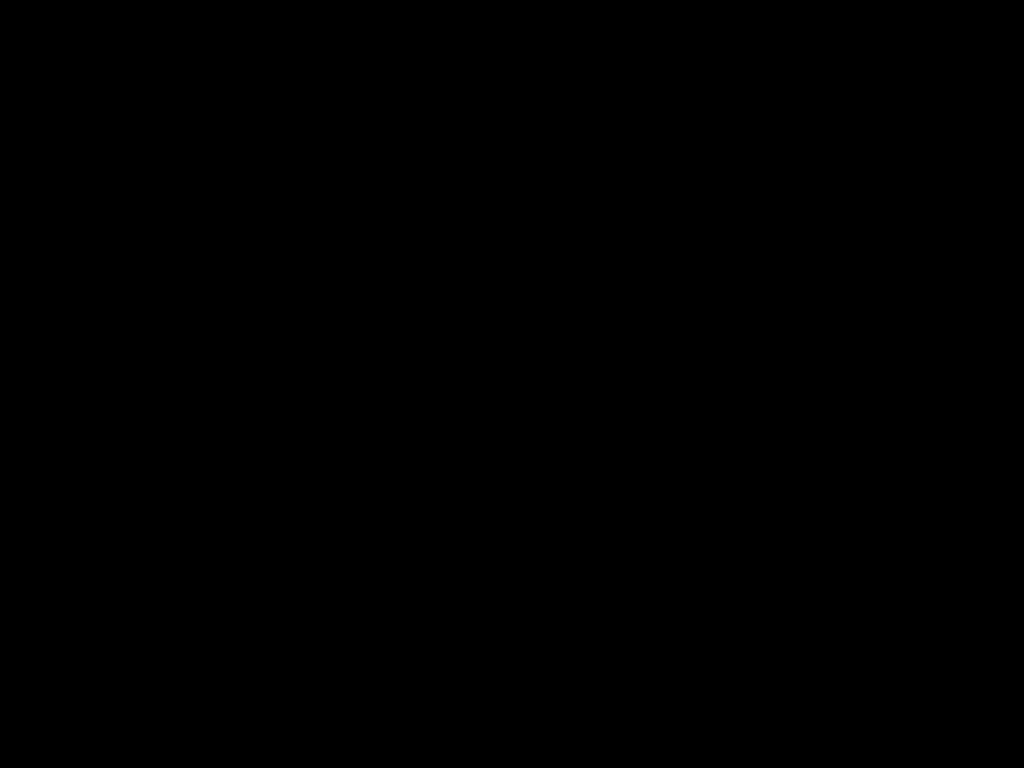

In [42]:
def draw_triangle(buffer: np.ndarray, corners: np.ndarray, color=255):
    a, b, c = np.vsplit(corners, 3)
    area = edge(a, b, c)
    # bounding box
    xmin, ymin = np.min(corners, axis=0).astype(int)
    xmax, ymax = np.max(corners, axis=0).astype(int) + 1

    x, y = np.mgrid[xmin:xmax, ymin:ymax]
    p = np.vstack([x.ravel(), y.ravel()]).T

    # evaluate all three edge functions
    ab = edge(a, b, p)
    bc = edge(b, c, p)
    ca = edge(c, a, p)
    inside = np.all([ab >= 0, bc >= 0, ca >= 0], axis=0)
    buffer[y.ravel()[inside], x.ravel()[inside], :] = color
    

buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
screen = to_screen(orthographic(vertices[triangle, :]), resolution)
draw_triangle(buffer, screen)
show_buffer(buffer)

# Mesh representation
Meshes, in its basic form, consists of a set of faces. For storage and manipulation vertices are normally _de-duplicated_, while for rendering vertices are normally _duplicated_ as it increase rendering speed.

In the de-duplicated format you have a vertex list and a face list. Normally only triangles are considered.

In [23]:
from typing import TextIO

def load_obj(f: TextIO) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Load object file and return mesh
    Args:
        f: open OBJ file to load.
    Returns:
        vertices: Mesh vertices.
        normals: Surface normals.
        faces: List of triangles.
    """
    vertices = []
    normals = []
    faces = []
    vertex_normals = []
    texture_coords = []
    for line in f:
        if line.startswith('#'):
            continue
        values = line.split()
        if not values:
            continue
        if values[0] == 'v':
            vertices.append(list(map(float, values[1:4])))
        elif values[0] == 'vn':
            normals.append(list(map(float, values[1:4])))
        elif values[0] == 'vt':
            continue
        elif values[0] == 'f':
            face_chunks = []
            for v in values[1:]:
                p = v.split('/')
                face_chunks.append(int(p[0]))
                # Format: v1/vt1
                if len(p) >= 2 and p[1]:
                    texture_coords.append(int(p[1]))
                # Format: v1/vt1/vn1 or v1//vn1
                if len(p) >= 3 and p[2]:
                    vertex_normals.append(int(p[2]))
            faces.append(face_chunks)

    # Return as numpy arrays and make faces 0-based, obj is 1-based.
    return np.asarray(vertices), np.asarray(faces, dtype=int) - 1, np.asarray(normals)

In [43]:
with open('left.obj') as f:  # samuels foot
    vertices, triangles, normals = load_obj(f)

print('vertices:', len(vertices), 'triangles:', len(triangles))
print(vertices)
print(triangles)

vertices: 2553 triangles: 5102
[[-1.9520e-03  1.4092e-02  2.7000e-04]
 [ 4.6650e-03  1.4164e-02  3.9000e-05]
 [-6.3870e-03  1.6252e-02  2.3300e-04]
 ...
 [ 1.8310e-03  9.1643e-02  1.4284e-01]
 [ 1.6170e-03  9.1654e-02  1.4284e-01]
 [ 3.1576e-02  5.3052e-02  1.4284e-01]]
[[  84   26   88]
 [  29   90   88]
 [  26   29   88]
 ...
 [2498 2518 2489]
 [2489 2552 2462]
 [2489 2462 2498]]


In [44]:
# same code as before, just different vertices
t = np.array([0, -0.1, 0.4])
transforms = (rotate_y(theta) for theta in np.linspace(0, tau, 200))
frames = [draw_frame(transform, t, vertices, project=perspective) for transform in transforms]
display_gif(frames, framerate=1/30, width=512)

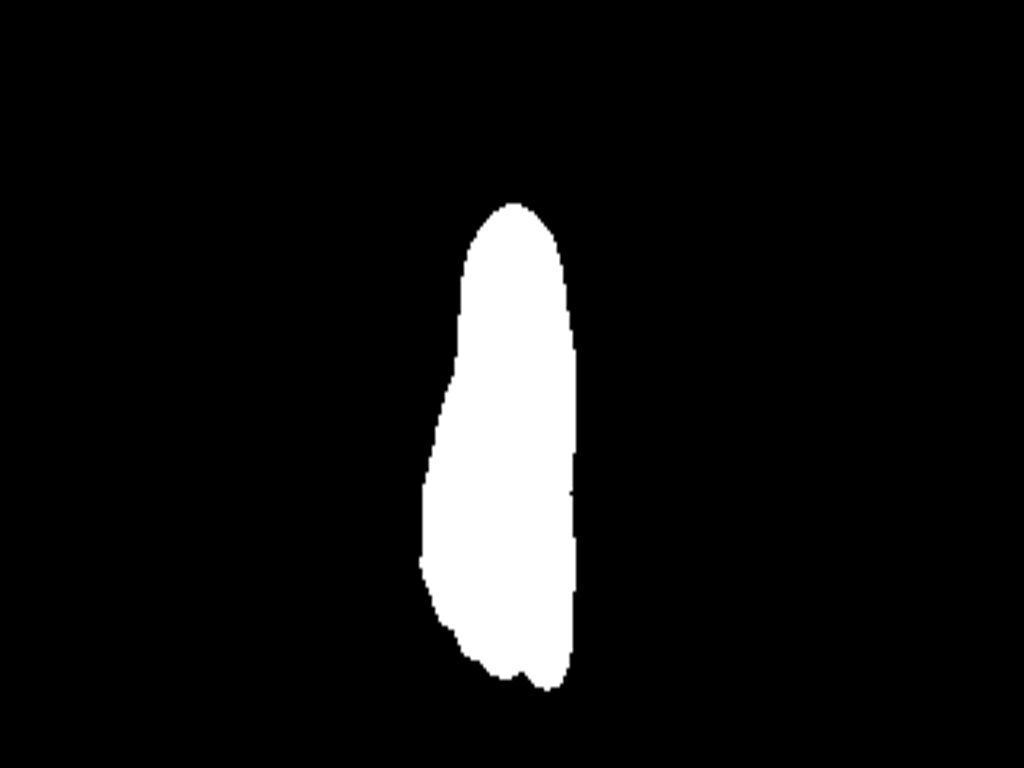

In [45]:
def draw_mesh(buffer, vertices, triangles):
    screen = to_screen(perspective(vertices), resolution)
    for triangle in triangles:
        draw_triangle(buffer, screen[triangle])

buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
draw_mesh(buffer, vertices + t, triangles)
show_buffer(buffer)

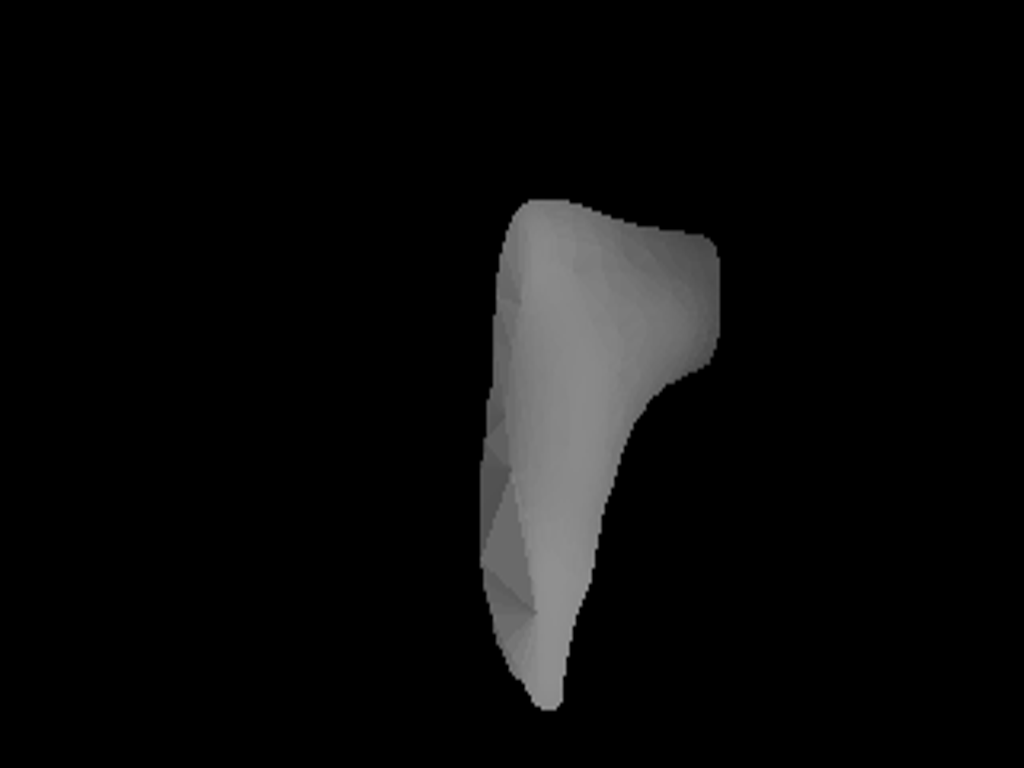

In [63]:
def draw_mesh(buffer, vertices, triangles):
    screen = to_screen(perspective(vertices), resolution)
    for triangle in triangles:
        mean_z = np.mean(vertices[triangle], axis=0)[2]
        draw_triangle(buffer, screen[triangle], color=1 - mean_z*1000)

buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
draw_mesh(buffer, transform(rotate_y(theta=-1.1), vertices) + t, triangles)
show_buffer(buffer)

In [67]:
%%time
def draw_frame(vertices, triangles):
    buffer = np.zeros((h, w, 3), dtype=np.uint8)  # create new frame
    draw_mesh(buffer, vertices, triangles)
    return buffer

t = np.array([0, -0.1, 0.4])
thetas = np.linspace(0, tau, 50)

frames = [draw_frame(transform(rotate_y(theta), vertices) + t, triangles) for theta in thetas]
display_gif(frames, framerate=1/30, width=512)

CPU times: user 12.9 s, sys: 30.5 ms, total: 12.9 s
Wall time: 12.9 s


## Quizz time!
The edge function...
* Computes a function at the compute edge, similar to a cloud function
* Is one permutation of the three edges of the triangle
* Computes the signed distance to the line of an edge